In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Input, concatenate, GlobalAveragePooling2D, Rescaling
from keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint



In [24]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Regular train/test data

In [ ]:
import zipfile
import os

train_zip = zipfile.ZipFile("/content/drive/MyDrive/train.zip", 'r')
train_zip.extractall('/tmp')
train_zip.close()

test_zip = zipfile.ZipFile("/content/drive/MyDrive/test.zip", 'r')
test_zip.extractall('/tmp')
test_zip.close()


#Unsharp Equalised Images

In [28]:
import zipfile
import os

train_zip = zipfile.ZipFile("/content/drive/MyDrive/equalised-unsharp-train-images.zip", 'r')
train_zip.extractall('/tmp')
train_zip.close()

test_zip = zipfile.ZipFile("/content/drive/MyDrive/equalised-unsharp-test-images.zip", 'r')
test_zip.extractall('/tmp')
test_zip.close()

#Generate Regular Images

In [ ]:


# Initialize image data generator with rescaling and augmentation
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,  # Randomly shift the width of images by up to 20%
    height_shift_range=0.2, # Randomly shift the height of images by up to 20%
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Randomly zoom in/out
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'    # Fill mode for handling newly created pixels after augmentation
)

validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all train images with augmentation
train_generator = train_data_gen.flow_from_directory(
        '/tmp/train',
        target_size=(48, 48),
        batch_size=120,
        color_mode="grayscale",
        class_mode='categorical')

# Preprocess all validation images without augmentation
validation_generator = validation_data_gen.flow_from_directory(
        '/tmp/test',
        target_size=(48, 48),
        batch_size=120,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


#Generate Unsharp Equaliseed Images

In [29]:


# Initialize image data generator with rescaling and augmentation
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,  # Randomly shift the width of images by up to 20%
    height_shift_range=0.2, # Randomly shift the height of images by up to 20%
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Randomly zoom in/out
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'    # Fill mode for handling newly created pixels after augmentation
)

validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all train images with augmentation
train_generator = train_data_gen.flow_from_directory(
        '/tmp/equalised-unsharp-train-images',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# Preprocess all validation images without augmentation
validation_generator = validation_data_gen.flow_from_directory(
        '/tmp/equalised-unsharp-test-images',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


##RGB Images

In [ ]:
# Define paths to your train and test data directories
train_data_dir = '/tmp/train'
test_data_dir = '/tmp/test'

# Create ImageDataGenerator instances for train and test data
train_data_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_data_gen = ImageDataGenerator(rescale=1.0 / 255)

# Define batch size and target image size
batch_size = 64
target_size = (48, 48)

# Load and preprocess the train and test datasets using flow_from_directory
train_generator = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',  # Ensure RGB color mode
    class_mode='categorical'
)

test_generator = test_data_gen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',  # Ensure RGB color mode
    class_mode='categorical'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


#Best Model

In [30]:
import tensorflow as tf

In [31]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)#the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)#the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)#the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)

    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)#Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)# create model
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())

    return model

model = FER_Model()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=1e-6,
    staircase=True)

opt = Adam(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_17 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_18 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0   

In [32]:
checkpoint_path = "/content/drive/MyDrive/model_checkpoint.h5"

In [35]:
new_checkpoint_path = "/content/drive/MyDrive/new_model_checkpoint.h5"

# Create a ModelCheckpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    new_checkpoint_path,
    monitor='val_accuracy',  # Choose a metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # If monitoring 'val_loss', use 'min' mode; if 'val_accuracy', use 'max' mode
    verbose=1  # Display progress during training
)

#Train New Model

In [36]:

num_epochs = 100
best_model = model.fit(
                    train_generator,
                    steps_per_epoch=28709 // 64,
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps= 7178//64,
                    callbacks=[model_checkpoint]
                    )

Epoch 1/100
448/448 [==============================] - ETA: 0s - loss: 2.2768 - accuracy: 0.2239
Epoch 1: val_accuracy improved from -inf to 0.24721, saving model to /content/drive/MyDrive/new_model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 53s 115ms/step - loss: 2.2768 - accuracy: 0.2239 - val_loss: 1.8333 - val_accuracy: 0.2472
Epoch 2/100
448/448 [==============================] - ETA: 0s - loss: 1.7678 - accuracy: 0.2718
Epoch 2: val_accuracy did not improve from 0.24721
448/448 [==============================] - 49s 109ms/step - loss: 1.7678 - accuracy: 0.2718 - val_loss: 2.0959 - val_accuracy: 0.2313
Epoch 3/100
448/448 [==============================] - ETA: 0s - loss: 1.6640 - accuracy: 0.3434
Epoch 3: val_accuracy improved from 0.24721 to 0.41839, saving model to /content/drive/MyDrive/new_model_checkpoint.h5
448/448 [==============================] - 49s 109ms/step - loss: 1.6640 - accuracy: 0.3434 - val_loss: 1.6413 - val_accuracy: 0.4184
Epoch 4/100
448/448 [==============================] - ETA: 0s - loss: 1.5228 - accuracy: 0.4055
Epoch 4: val_accuracy improved from 0.41839 to 0.43025, saving model to /content/drive/MyDrive/new_model_checkpoint.h5
448/448 [=========

#Load model and train


In [8]:
loaded_model = tf.keras.models.load_model(checkpoint_path)
num_epochs = 50
best_model = loaded_model.fit(
                    train_generator,
                    steps_per_epoch=28709 // 64,
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps= 7178//64,
                    callbacks=[model_checkpoint]
                    )



Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 0.9090 - accuracy: 0.6634
Epoch 1: val_accuracy improved from -inf to 0.69266, saving model to /content/drive/MyDrive/model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 58s 101ms/step - loss: 0.9090 - accuracy: 0.6634 - val_loss: 0.8481 - val_accuracy: 0.6927
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 0.9007 - accuracy: 0.6671
Epoch 2: val_accuracy improved from 0.69266 to 0.71038, saving model to /content/drive/MyDrive/model_checkpoint.h5
448/448 [==============================] - 46s 103ms/step - loss: 0.9007 - accuracy: 0.6671 - val_loss: 0.7738 - val_accuracy: 0.7104
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 0.8983 - accuracy: 0.6658
Epoch 3: val_accuracy improved from 0.71038 to 0.71708, saving model to /content/drive/MyDrive/model_checkpoint.h5
448/448 [==============================] - 47s 105ms/step - loss: 0.8983 - accuracy: 0.6658 - val_loss: 0.7591 - val_accuracy: 0.7171
Epoch 4/50
448/448 [==============================] - ETA: 0s - loss: 0.8951 - accuracy: 0.6711
Epoch 4: val_accuracy did not improve from 0.71708
448/448 [====================

#PAPER 70% giving 59%

In [ ]:

# Define the model based on the provided architecture and hyperparameters
model = Sequential([
    # Rescaling layer to normalize the input images
    # Rescaling(1./255, input_shape=(48, 48, 1)),

    # Convolutional layers
    Conv2D(48, kernel_size=(3, 3), activation='relu'),
    Conv2D(48, kernel_size=(3, 3), activation='relu'),

    # MaxPooling and Dropout layers
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    Dropout(0.5),

    # More Convolutional layers
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),

    # MaxPooling and Dropout layers
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    # Even more Convolutional layers
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),

    # MaxPooling and Dropout layers
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    Dropout(0.5),

    # Flatten the output to feed into the dense layers
    Flatten(),

    # Dense layers with dropout
    Dense(1024, activation='relu'),
    Dropout(0.5),

    # Output layer with 7 classes for FER2013 dataset
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # Use categorical_crossentropy instead of sparse_categorical_crossentropy
    metrics=['accuracy']
)


In [ ]:
emotion_model_info = model.fit(
        train_generator,
        steps_per_epoch=28709 // 120,
        epochs=80,
        validation_data=validation_generator,
        validation_steps=7178 // 120)

Epoch 1/80
239/239 [==============================] - 32s 130ms/step - loss: 1.8226 - accuracy: 0.2485 - val_loss: 1.8149 - val_accuracy: 0.2463
Epoch 2/80
239/239 [==============================] - 32s 134ms/step - loss: 1.8122 - accuracy: 0.2514 - val_loss: 1.8072 - val_accuracy: 0.2480
Epoch 3/80
239/239 [==============================] - 33s 138ms/step - loss: 1.8032 - accuracy: 0.2509 - val_loss: 1.7910 - val_accuracy: 0.2469
Epoch 4/80
239/239 [==============================] - 30s 126ms/step - loss: 1.7951 - accuracy: 0.2514 - val_loss: 1.7987 - val_accuracy: 0.2468
Epoch 5/80
239/239 [==============================] - 31s 131ms/step - loss: 1.7822 - accuracy: 0.2610 - val_loss: 1.7157 - val_accuracy: 0.3007
Epoch 6/80
239/239 [==============================] - 34s 143ms/step - loss: 1.7469 - accuracy: 0.2806 - val_loss: 1.6876 - val_accuracy: 0.3049
Epoch 7/80
239/239 [==============================] - 36s 152ms/step - loss: 1.7242 - accuracy: 0.2917 - val_loss: 1.6762 - val_ac

In [9]:
import matplotlib.pyplot as plt


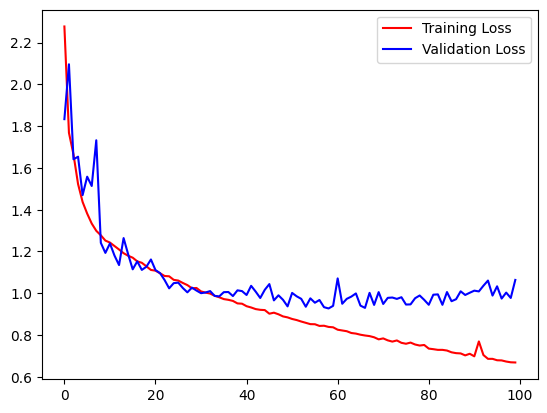

In [37]:
plt.plot(best_model.history["loss"],'r', label="Training Loss")
plt.plot(best_model.history["val_loss"],'b', label="Validation Loss")
plt.legend()

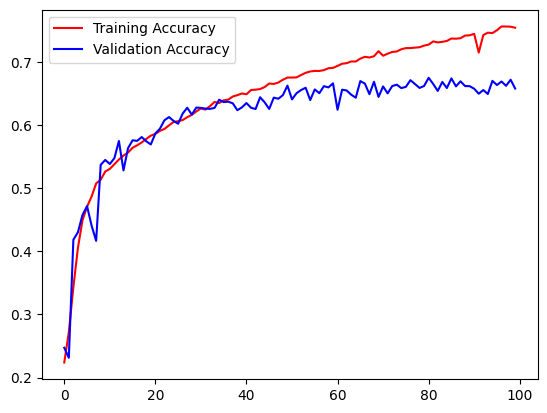

In [38]:
plt.plot(best_model.history["accuracy"],'r',label="Training Accuracy")
plt.plot(best_model.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

Found 7178 images belonging to 7 classes.
113/113 [==============================] - 5s 38ms/step
-----------------------------------------------------------------
[[133  14 102 227 182 174 126]
 [ 12   0  12  22  25  21  19]
 [106   6 131 265 237 151 128]
 [207  17 234 460 356 279 221]
 [164   6 143 339 251 187 143]
 [146  17 145 304 255 210 170]
 [ 91  13 105 218 167 135 102]]


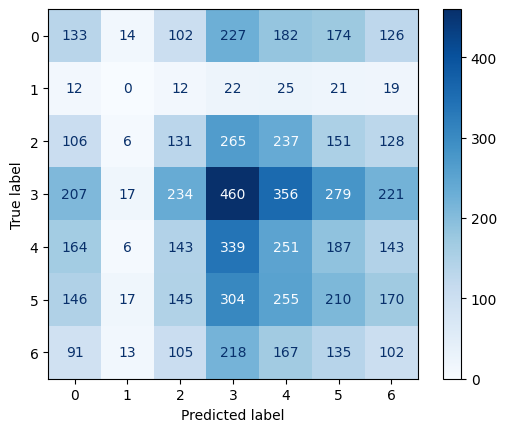

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.15      0.14      0.15       958
           1       0.00      0.00      0.00       111
           2       0.15      0.13      0.14      1024
           3       0.25      0.26      0.25      1774
           4       0.17      0.20      0.19      1233
           5       0.18      0.17      0.17      1247
           6       0.11      0.12      0.12       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.18      0.18      0.18      7178



In [41]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

emotion_dict = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}
test_data_gen = ImageDataGenerator(rescale=1./255)

  # Adjust the path as needed
loaded_model = tf.keras.models.load_model(new_checkpoint_path)



# Preprocess all test images
test_generator = test_data_gen.flow_from_directory(
        '/tmp/equalised-unsharp-test-images',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# do prediction on test data
predictions = loaded_model.predict(test_generator)

# # see predictions
# for result in predictions:
#     max_index = int(np.argmax(result))
#     print(emotion_dict[max_index])

print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(test_generator.classes, predictions.argmax(axis=1)))


#TEST ON IMAGE

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# # Define the file path to your image on the mounted drive
# image_path = '/content/drive/MyDrive/happy.jpg'  # Replace 'your_image.png' with the actual file name

# # Load the image using Pillow
# img = Image.open(image_path)
# grayscale_image = img.convert('L')
# # # Load the saved model
# # loaded_model = tf.keras.models.load_model('emotion_recognition_model.h5')

# # # Load your own image for testing
# # img_path = 'path_to_your_image.jpg'  # Replace with the path to your image file
# # img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
# img_array = image.img_to_array(grayscale_image)
# img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# # Preprocess the image (rescale to [0, 1])
# img_array /= 255.0
# img_array = img_array.reshape((48, 48, 1))

batch_x, batch_y = next(test_generator)

# Choose one image from the batch (e.g., the first image in the batch)
one_image = batch_x[0]
# Make predictions
predictions = loaded_model.predict(one_image)

# The 'predictions' variable now contains the model's output, which is a probability distribution over the 7 emotion categories
# You can interpret the results to get the predicted emotion category
predicted_emotion = np.argmax(predictions[0])  # Get the index of the highest probability
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
predicted_emotion_label = emotion_labels[predicted_emotion]
print('predicted: '+predicted_emotion_label,'actual: ' +emotion_labels[batch_y[0]])